In [1]:
import train
import torch
import pathlib

device = torch.device("cuda")

manager = train.load_data(torch.device("cuda"),
                          data_path=pathlib.Path("C:/Users/imeho/Documents/DataSets/InstantPINF/ScalarReal"))

Caching all 480 images.

Output()

Caching all 120 images.

Output()

In [2]:
from nerfstudio.model_components.ray_samplers import UniformSampler
from nerfstudio.model_components.scene_colliders import NearFarCollider

collider = NearFarCollider(near_plane=1.1, far_plane=1.5)
sampler_uniform = UniformSampler(num_samples=192)

In [3]:
import src.encoder as encoder
import taichi as ti
import numpy as np

ti.init(arch=ti.cuda)
xyzt_encoder = encoder.HashEncoderHyFluid(
    min_res=np.array([16, 16, 16, 16]),
    max_res=np.array([256, 256, 256, 128]),
    num_scales=16,
    max_params=2 ** 19,
)
xyzt_encoder.to(device)

[Taichi] version 1.7.2, llvm 15.0.1, commit 0131dce9, win, python 3.11.0
[Taichi] Starting on arch=cuda


HashEncoderHyFluid()

In [4]:
from nerfstudio.field_components.mlp import MLP
import src.radam as radam

mlp_base = MLP(
    in_dim=xyzt_encoder.num_scales * xyzt_encoder.features_per_level,
    num_layers=2,
    layer_width=64,
    out_dim=1,
    out_activation=torch.nn.ReLU(),
)
mlp_base.to(device)
learned_rgb = torch.nn.Parameter(torch.tensor([0.0], device=device))

grad_vars = list(mlp_base.parameters()) + [learned_rgb]
embedding_params = list(xyzt_encoder.parameters())

optimizer = radam.RAdam([
    {'params': grad_vars, 'weight_decay': 1e-6},
    {'params': embedding_params, 'eps': 1e-15}
], lr=0.01, betas=(0.9, 0.99))

In [5]:
raw2alpha = lambda raw, dists, act_fn=torch.nn.functional.relu: 1. - torch.exp(-act_fn(raw) * dists)

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


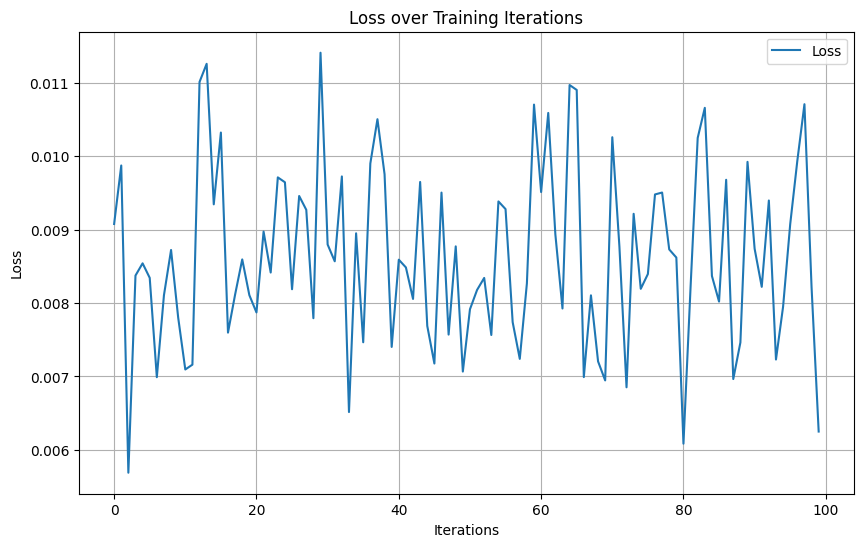

In [6]:
from nerfstudio.model_components.losses import MSELoss
import tqdm
import matplotlib.pyplot as plt

import src.datamanager as datamanager

loss_history = []

for i in tqdm.tqdm(range(100)):
    ray_bundle, batch = manager.next_train()
    collider(ray_bundle)
    ray_samples_uniform = sampler_uniform(ray_bundle)
    positions = ray_samples_uniform.frustums.get_positions()
    frames = datamanager.image_idx_to_frame(
        image_indices=batch['indices'][:, 0],
        all_frames=manager.train_dataset.metadata['all_frames'])
    frames_expanded = frames.to(device).view(positions.shape[0], 1, 1).expand(-1, positions.shape[1], -1)
    xyzt = torch.cat((positions, frames_expanded), dim=-1)
    xyzt_flat = xyzt.reshape(-1, 4)
    xyzt_encoded = xyzt_encoder(xyzt_flat)

    raw_flat = mlp_base(xyzt_encoded)
    raw = raw_flat.reshape(xyzt.shape[0], xyzt.shape[1], raw_flat.shape[-1])

    dists = ray_samples_uniform.deltas
    rgb = torch.ones(3, device=device) * (0.6 + torch.tanh(learned_rgb) * 0.4)
    alpha = raw2alpha(raw[..., -1], dists[..., -1])
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1), device=device), 1. - alpha + 1e-10], -1),
                                    -1)[:, :-1]
    rgb_map = torch.sum(weights[..., None] * rgb, -2)

    rgb_loss = MSELoss()
    image = batch['image'].to(device)
    loss = rgb_loss(rgb_map, image)
    loss_history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    new_lrate = 5e-4 * (0.1 ** (i / 250))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lrate

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over Training Iterations")
plt.legend()
plt.grid()
plt.show()

torch.Size([1024, 3])

In [1]:
import src.dataloader as dl
import torch
import pathlib

dataloader = dl.load_train_data(pathlib.Path("C:/Users/imeho/Documents/DataSets/InstantPINF/ScalarReal"), "train",
                                device=torch.device("cuda"))
iter = iter(dataloader)
image_batch = next(iter)

print(f'image device: {image_batch["image"].device}')
memory_image_cuda = image_batch['image'].element_size() * image_batch['image'].numel()
print(f'Memory of image: {memory_image_cuda / 1024 / 1024:.2f} MB')

Caching all 480 images.

Output()

image device: cuda:0
Memory of image: 11390.62 MB


In [9]:
import nerfstudio.data.pixel_samplers

ps = nerfstudio.data.pixel_samplers.PixelSamplerConfig(num_rays_per_batch=1024).setup()
batch = ps.sample(image_batch)

print(batch.keys())
print(batch['image'])
print(batch['indices'])

dict_keys(['image', 'indices'])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')
tensor([[ 336, 1193,   69],
        [ 312, 1454,  157],
        [  31,  384,   25],
        ...,
        [ 146, 1036,  349],
        [ 137,  591,  274],
        [ 330,  544,  239]], device='cuda:0')
